# Binary Phase Field Benchmark

FiPy implementation of phase transormation in 2D with solutal driving force

**Do not edit `binary_phase_field.py`**. Generate the batch-runnable file from the notebook with
```bash
jupyter nbconvert binary_phase_field.ipynb --to python --output-dir=../scripts/
```

## Import Python modules

In [1]:
import argparse
import json
import os
import re
import sys

import fipy as fp
from fipy.tools import numerix as nmx
from fipy.tools import parallelComm

Jupyter notebook handles some things differently than from the commandline

In [2]:
try:
    from IPython import get_ipython
    isnotebook = get_ipython() is not None
except:
    isnotebook = False

## Initialize
### Load parameters

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--output", help="directory to store results in",
                    default=None)
parser.add_argument("--store_by_solver",
                    help="store results in nested subdirectories based on solver,"
                    "preconditioner, and system size",
                    action='store_true')
parser.add_argument("--restart", help="solution to initialize from",
                    default=None)
parser.add_argument("--checkpoint_interval", help="frequency to save results",
                    type=float, default=6.)
parser.add_argument("--totaltime", help="duration of full simulation",
                    type=float, default=600.)
parser.add_argument("--numnuclei", help="number of nuclei",
                    type=int, default=100)
parser.add_argument("--factor", help="fraction of critical nucleus size for new nuclei",
                    type=float, default=1.1)
parser.add_argument("--nucleation_scale", help="size of domain for nuclei",
                    type=float, default=1000)
parser.add_argument("--numberOfElements", help="number of total cells in a Grid2D",
                    type=int, default=1000000)
parser.add_argument("--solver", help="solver class to use",
                    choices=("pcg", "cgs", "gmres", "lu"), default="pcg")
parser.add_argument("--preconditioner", help="preconditioner class to use",
                    choices=("jacobi", "ilu", "ssor", "icc", "none"), default="none")
parser.add_argument("--sweeps", help="number of nonlinear sweeps to take",
                    type=int, default=5)
parser.add_argument("--iterations", help="maximum number of linear iterations to take for each sweep",
                    type=int, default=1000)
parser.add_argument("--tolerance", help="linear solver tolerance",
                    type=float, default=1e-10)
parser.add_argument("--store_matrix",
                    help="store the matrix and RHS vector along with other output",
                    action='store_true')
parser.add_argument("--gradient2thermal",
                    help="strength of gradient energy relative to thermal energy",
                    type=float, default=1)
parser.add_argument("--segregation2transformation",
                    help="strength of segregation relative to transformation driving force",
                    type=float, default=1)
parser.add_argument("--adsorption",
                    help="strength of relative adsorption",
                    type=float, default=0)

_StoreAction(option_strings=['--adsorption'], dest='adsorption', nargs=None, const=None, default=0, type=<class 'float'>, choices=None, required=False, help='strength of relative adsorption', metavar=None)

### Set any parameters for interactive notebook

In [101]:
if isnotebook:
    # argv = ["--numberOfElements=10000", "--totaltime=1.2", "--checkpoint_interval=0.12",
    #         "--nucleation_scale=100", "--output=nucleation6"]
    argv = ["--numberOfElements=100000", "--nucleation_scale=1000", "--output=solidification3",
            "--segregation2transformation=6.",
           "--restart=../../results/nucleation/nucleation18/t=300.0.npz",
           "--store_matrix"]
else:
    argv = None

In [102]:
args, unknowns = parser.parse_known_args(args=argv)

### Initialize mesh and solution variables

Either restart from some `path/to/restart/t={time}.npz`, where the time is assigned to `elapsed`

or

Create a mesh based on parameters. Set
>  the computational domain is ... 1000×1000 

In [103]:
nx = ny = int(nmx.sqrt(args.numberOfElements))
mesh = fp.Grid2D(nx=nx, ny=ny)
phi = fp.CellVariable(mesh=mesh, name="$\phi$", value=0., hasOld=True)
elapsed = 0.

In [104]:
if args.restart is not None:
    data = nmx.load(args.restart)
    lower, upper = int((1000 - nx) / 2), int((1000 + nx) / 2)
    phi.setValue(data["phi"][lower:upper, lower:upper].flat)

    # scanf("%g") simulator
    # https://docs.python.org/3/library/re.html#simulating-scanf
    scanf_g = "[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?"
    pattern = ".*t=({g})\.npz".format(g=scanf_g)
    elapsed = float(re.match(pattern, args.restart).group(1))

In [105]:
x, y = mesh.cellCenters[0], mesh.cellCenters[1]
X, Y = mesh.faceCenters[0], mesh.faceCenters[1]

In [106]:
C = fp.CellVariable(mesh=mesh, name="$C$", value=0.7 - 0.4 * phi, hasOld=True)

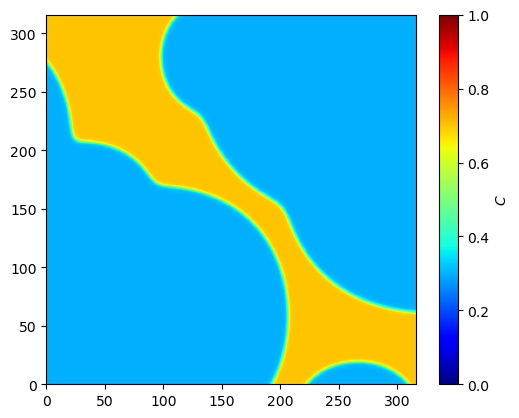

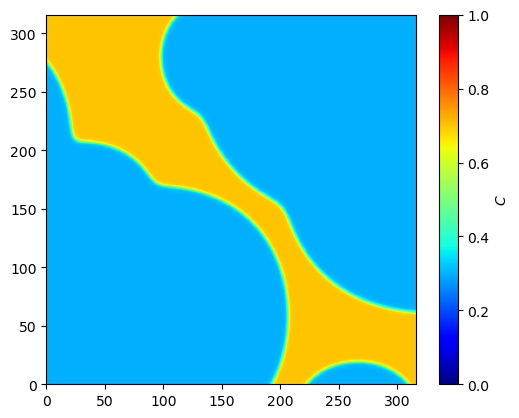

In [107]:
if isnotebook:
    viewer = fp.Viewer(vars=C, datamin=0., datamax=1.)
    viewer.plot()

## Create solver

In [108]:
precon = None

if args.preconditioner == "jacobi":
    precon = fp.JacobiPreconditioner()
elif args.preconditioner == "ilu":
    precon = fp.ILUPreconditioner()
elif args.preconditioner == "ssor":
    precon = fp.SSORPreconditioner()
elif args.preconditioner == "icc":
    precon = fp.ICPreconditioner()
elif args.preconditioner == "none":
    precon = None

if args.solver == "cgs":
    solver_class = fp.LinearCGSSolver
elif args.solver == "gmres":
    solver_class = fp.LinearGMRESSolver
elif args.solver == "lu":
    if args.preconditioner != "none":
        # preconditioned lu doesn't make any sense
        exit()

    solver_class = fp.LinearLUSolver
elif args.solver == "pcg":
    solver_class = fp.LinearPCGSolver

solver = solver_class(tolerance=args.tolerance, criterion="initial",
                      iterations=args.iterations, precon=precon)

## Binary Alloy with Frozen Phase Field: governing equation

Given the strength of the phase transformation driving force,
$$\Delta f = \frac{1}{6\sqrt{2}}$$

In [109]:
Delta_f = 1 / (6 * nmx.sqrt(2.))

the strength of gradient energy relative to thermal energy, $\xi$,

In [110]:
xi = args.gradient2thermal

the strength of the segregation relative to the nucleation driving force, $\zeta$,

In [111]:
zeta = args.segregation2transformation

the strength of the relative adsorption, $\tilde{W}$,

In [112]:
Delta_W = args.adsorption

the phase interpolation function
\begin{align}
p(\phi) & \equiv \phi^3 (6\phi^2 - 15 \phi + 10
\end{align}

In [113]:
def p(phi):
    return phi**3 * (6 * phi**2 - 15 * phi + 10)

and the double well function
\begin{align}
g(\phi) & \equiv \phi^2 (1 - \phi)^2
\end{align}

In [114]:
def g(phi):
    return phi**2 * (1 - phi)**2

diffusion with convection due to frozen phase boundary can be described by
\begin{align}
\frac{\partial C}{\partial t} &= \nabla^2 C
+ \nabla\cdot\left[
    C\left(1-C\right)
    \xi
    \left(
        \zeta \Delta f p'(\phi)
        - \frac{\Delta\tilde{W}}{2} g'(\phi)
    \right)
    \nabla \phi\right]
\\
&= \nabla^2 C
+ \nabla\cdot\left[
    C\left(1-C\right)
    \xi
    \left(
        \zeta \Delta f \nabla p(\phi)
        - \frac{\Delta\tilde{W}}{2} \nabla g(\phi)
    \right)
\right]
\end{align}

In [115]:
phaseTransformationVelocity = (1 - C).harmonicFaceValue * xi * (zeta * Delta_f * p(phi).faceGrad 
                                                                - 0.5 * Delta_W * g(phi).faceGrad)

eq = (fp.TransientTerm(var=C)
      == fp.DiffusionTerm(var=C)
      + fp.ConvectionTerm(coeff=phaseTransformationVelocity, var=C))

## Free Energy

\begin{align}
\frac{f(\phi, C, T) V_m}{RT}
&= \xi \left\{ 
-\Delta f \left[1 + \frac{1}{2} (1 - 2C) \zeta
\right]p(\phi)\right.
\\
&\qquad \left. {} + \left[
1 - \frac{1}{2} (1 - 2C) \Delta\tilde{W}
\right] g(\phi)
\right\}
\\
&\qquad {} + \left[
    \left(1 - C\right)\ln\left(1 - C\right) + C\ln C
\right]
\end{align}

In [116]:
def f(phi, C):
    return (xi * (-Delta_f * (1 + 0.5 * (1 - 2 * C) * zeta) * p(phi)
                  + (1 + 0.5 * (1 - 2 * C) * Delta_W) * g(phi))
            + (1 - C) * nmx.log(1 - C) + C * nmx.log(C))

In [78]:
zeta = 0
xi = 1
Delta_W = 0

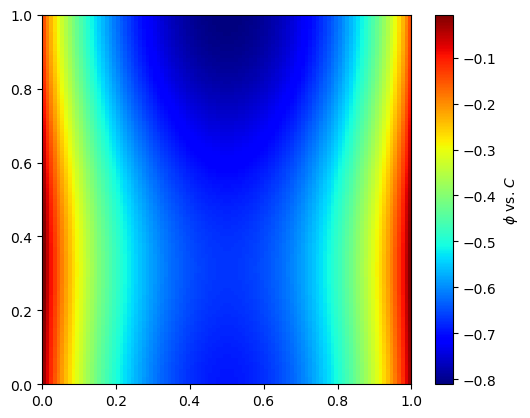

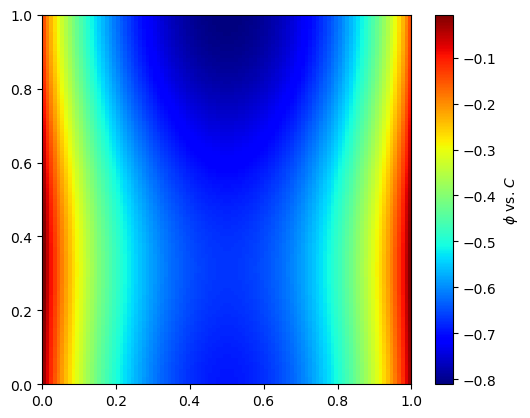

In [79]:
phi_C_mesh = fp.Grid2D(nx=100, Lx=1., ny=100, Ly=1.)
free_energy = f(phi=phi_C_mesh.y, C=phi_C_mesh.x)
free_energy.name = r"$\phi$ vs. $C$"
fp.Viewer(vars=free_energy)

In [80]:
zeta = 0
xi = 2
Delta_W = 0

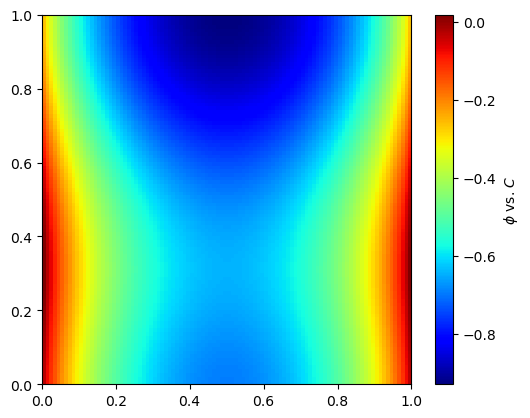

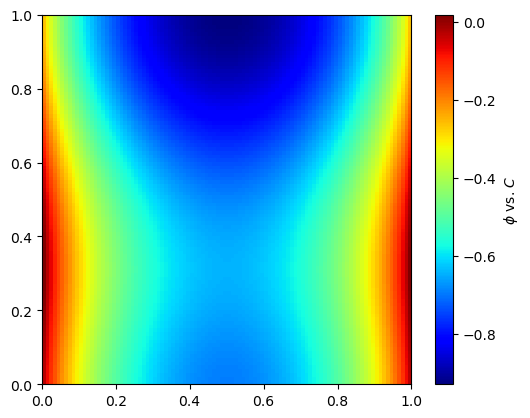

In [81]:
phi_C_mesh = fp.Grid2D(nx=100, Lx=1., ny=100, Ly=1.)
free_energy = f(phi=phi_C_mesh.y, C=phi_C_mesh.x)
free_energy.name = r"$\phi$ vs. $C$"
fp.Viewer(vars=free_energy)

In [82]:
zeta = 0
xi = 1
Delta_W = 2

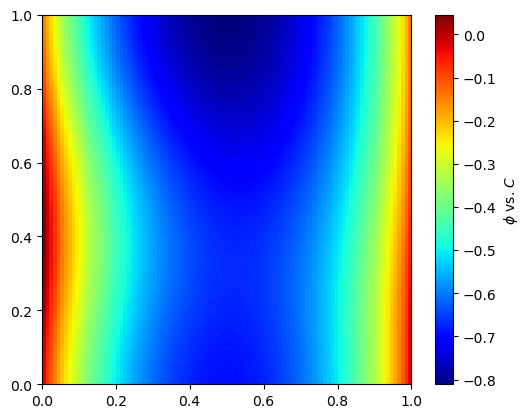

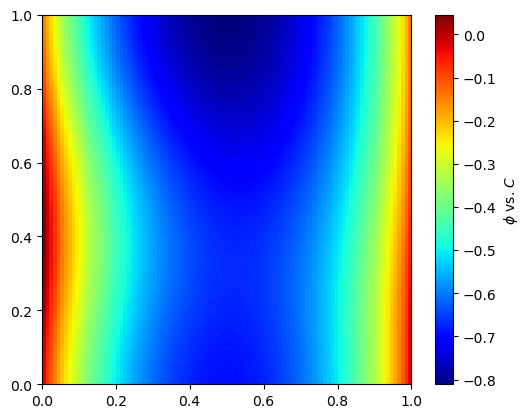

In [83]:
phi_C_mesh = fp.Grid2D(nx=100, Lx=1., ny=100, Ly=1.)
free_energy = f(phi=phi_C_mesh.y, C=phi_C_mesh.x)
free_energy.name = r"$\phi$ vs. $C$"
fp.Viewer(vars=free_energy)

In [84]:
zeta = 1
xi = 1
Delta_W = 0

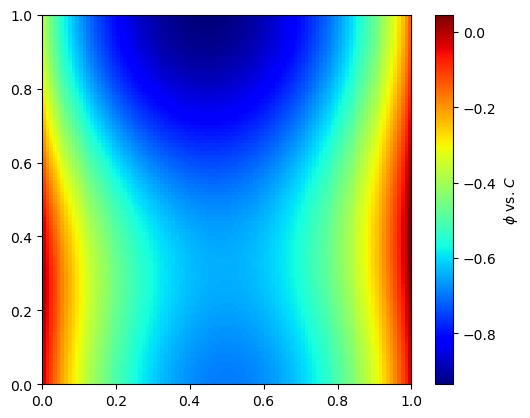

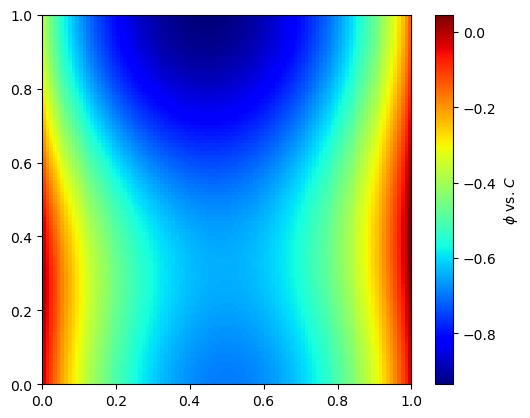

In [85]:
phi_C_mesh = fp.Grid2D(nx=100, Lx=1., ny=100, Ly=1.)
free_energy = f(phi=phi_C_mesh.y, C=phi_C_mesh.x)
free_energy.name = r"$\phi$ vs. $C$"
fp.Viewer(vars=free_energy)

In [86]:
zeta = 2
xi = 1
Delta_W = 0

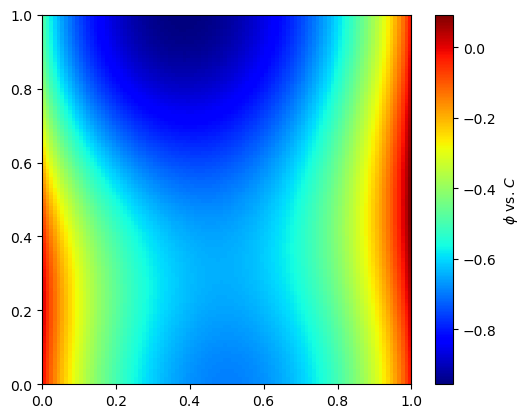

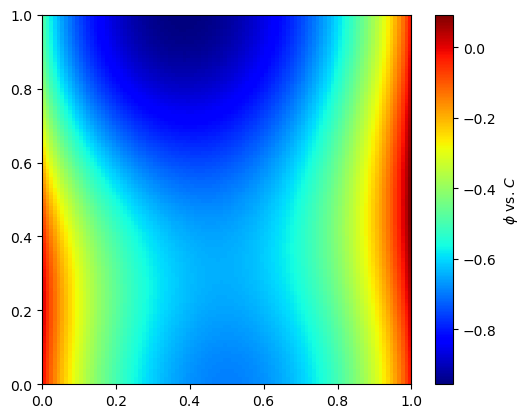

In [87]:
phi_C_mesh = fp.Grid2D(nx=100, Lx=1., ny=100, Ly=1.)
free_energy = f(phi=phi_C_mesh.y, C=phi_C_mesh.x)
free_energy.name = r"$\phi$ vs. $C$"
fp.Viewer(vars=free_energy)

In [88]:
zeta = 3
xi = 1
Delta_W = 0

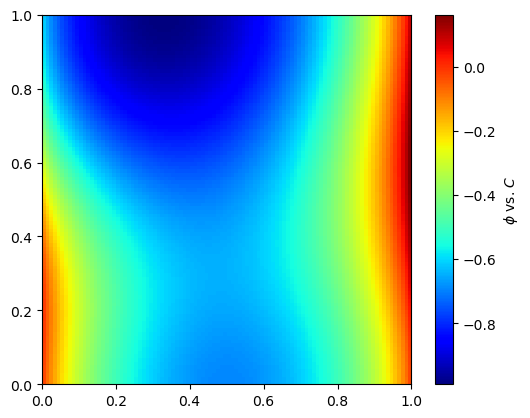

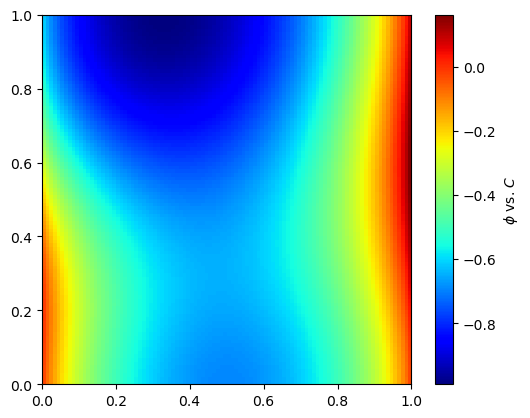

In [89]:
phi_C_mesh = fp.Grid2D(nx=100, Lx=1., ny=100, Ly=1.)
free_energy = f(phi=phi_C_mesh.y, C=phi_C_mesh.x)
free_energy.name = r"$\phi$ vs. $C$"
fp.Viewer(vars=free_energy)

In [93]:
zeta = 5
xi = 1
Delta_W = 0

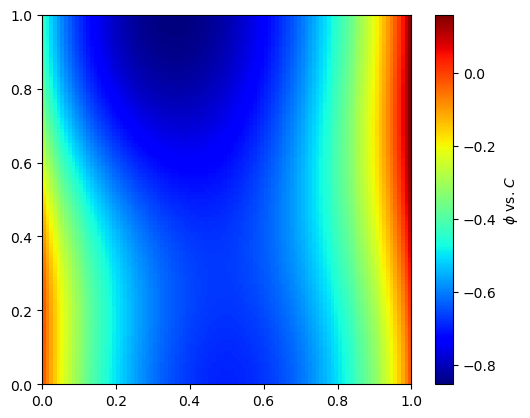

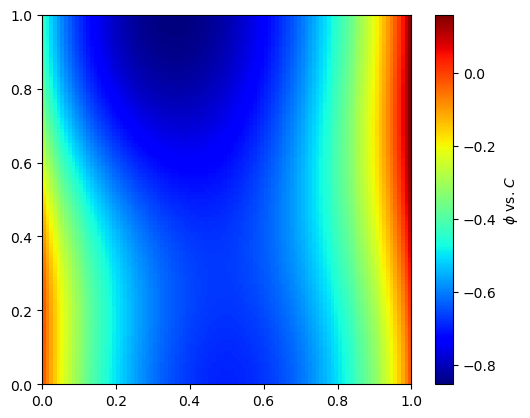

In [94]:
phi_C_mesh = fp.Grid2D(nx=100, Lx=1., ny=100, Ly=1.)
free_energy = f(phi=phi_C_mesh.y, C=phi_C_mesh.x)
free_energy.name = r"$\phi$ vs. $C$"
fp.Viewer(vars=free_energy)

In [99]:
zeta = 6
xi = 1
Delta_W = 0

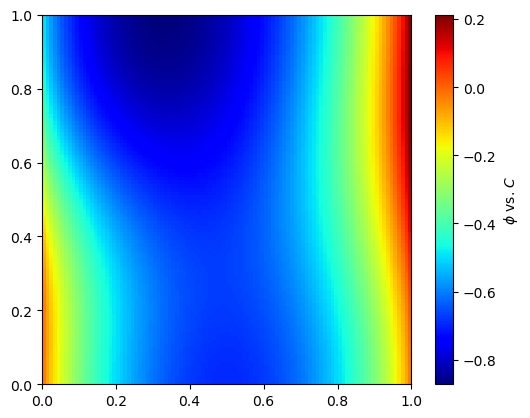

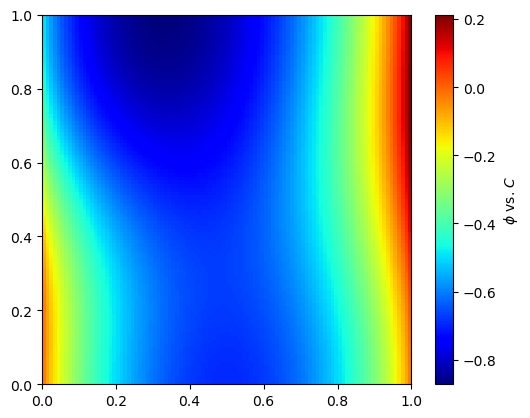

In [100]:
phi_C_mesh = fp.Grid2D(nx=100, Lx=1., ny=100, Ly=1.)
free_energy = f(phi=phi_C_mesh.y, C=phi_C_mesh.x)
free_energy.name = r"$\phi$ vs. $C$"
fp.Viewer(vars=free_energy)

In [95]:
zeta = 10
xi = 1
Delta_W = 0

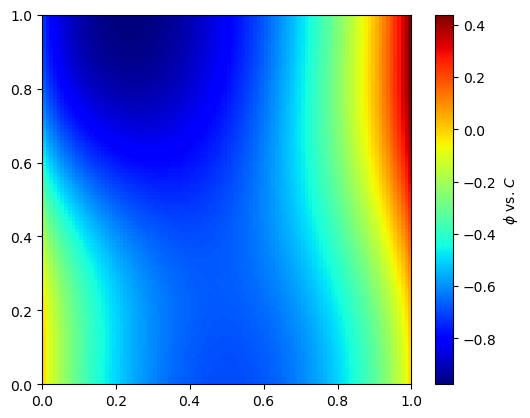

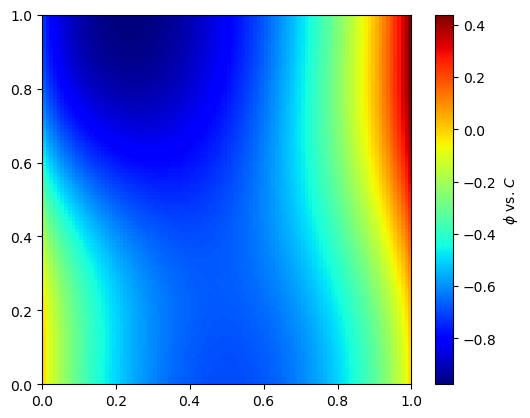

In [96]:
phi_C_mesh = fp.Grid2D(nx=100, Lx=1., ny=100, Ly=1.)
free_energy = f(phi=phi_C_mesh.y, C=phi_C_mesh.x)
free_energy.name = r"$\phi$ vs. $C$"
fp.Viewer(vars=free_energy)

In [97]:
zeta = 100
xi = 1
Delta_W = 0

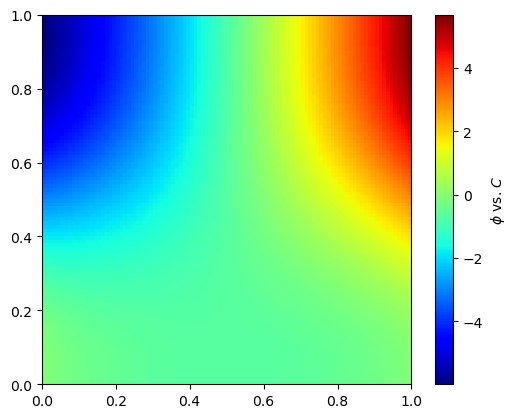

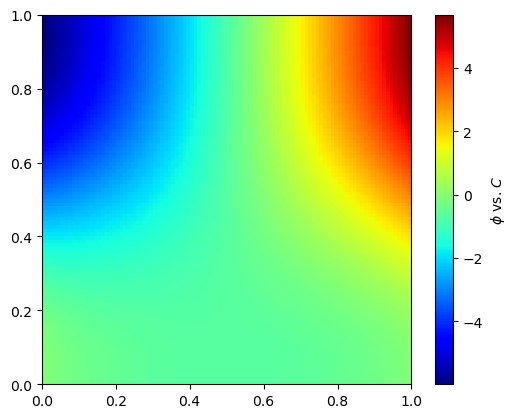

In [98]:
phi_C_mesh = fp.Grid2D(nx=100, Lx=1., ny=100, Ly=1.)
free_energy = f(phi=phi_C_mesh.y, C=phi_C_mesh.x)
free_energy.name = r"$\phi$ vs. $C$"
fp.Viewer(vars=free_energy)

## Setup output

### Setup ouput storage

In [117]:
if (args.output is not None) and (parallelComm.procID == 0):
    if args.store_by_solver:
        suite = solver.__module__.split('.')[2]
        if args.preconditioner is None:
            preconditioner_name = "none"
        else:
            preconditioner_name = precon.__class__.__name__
        path = os.path.join(args.output, suite,
                            solver.__class__.__name__,
                            preconditioner_name,
                            str(nx * ny))
    else:
        path = args.output

    os.makedirs(path)

if parallelComm.procID == 0:
    print("storing results in {0}".format(path))

storing results in solidification3


### Define output routines

In [118]:
def saveC(elapsed):
    C_value = C.globalValue.reshape((nx, ny))
    if parallelComm.procID == 0:
        fname = os.path.join(path, "t={}.npz".format(elapsed))
        nmx.savez(fname, C=C_value)

def saveMatrix(elapsed):
    mtxname = os.path.join(path, "t={}.mtx".format(elapsed))
    eq.matrix.exportMmf(mtxname)
    
    rhs_value = eq.RHSvector
    if parallelComm.procID == 0:
        rhsname = os.path.join(path, "t={}.rhs.npz".format(elapsed))
        nmx.savez(rhsname, rhs=rhs_value)

def checkpoint_data(elapsed, store_matrix=False):
    saveC(elapsed)
    if store_matrix:
        saveMatrix(elapsed)

### Figure out when to save

In [119]:
checkpoints = (fp.numerix.arange(int(elapsed / args.checkpoint_interval),
                                 int(args.totaltime / args.checkpoint_interval))
               + 1) * args.checkpoint_interval

checkpoints.sort()

## Solve and output

In [120]:
times = checkpoints
times = times[(times > elapsed) & (times <= args.totaltime)]

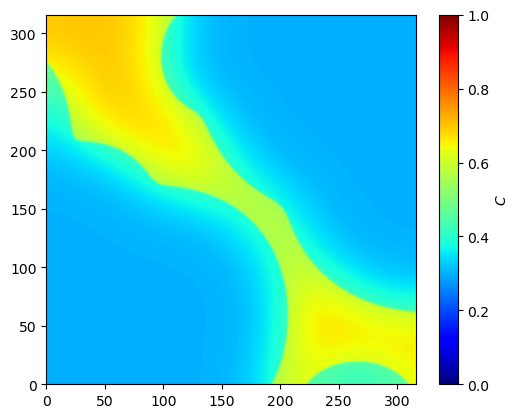

In [121]:
from steppyngstounes import CheckpointStepper, FixedStepper

eq.cacheMatrix()
eq.cacheRHSvector()

C.updateOld()
for checkpoint in CheckpointStepper(start=elapsed,
                                    stops=times,
                                    stop=args.totaltime):

    for step in FixedStepper(start=checkpoint.begin,
                             stop=checkpoint.end,
                             size=100.):

        state = dict(state="START", numberOfElements=mesh.numberOfCells, sweeps=args.sweeps)
        if precon is None:
            state["preconditioner"] = None
        else:
            state["preconditioner"] = precon.__class__.__name__

        solver._log.debug(json.dumps(state))

        for sweep in range(args.sweeps):
            res = eq.sweep(var=C, dt=step.size, solver=solver)

        state["state"] = "END"
        solver._log.debug(json.dumps(state))

        C.updateOld()
        # stats.append(current_stats(step.end))

        _ = step.succeeded(error=res / 1e-3)

    if checkpoint.end in checkpoints:
        # don't save nucleation events?
        checkpoint_data(checkpoint.end, store_matrix=args.store_matrix)

    if isnotebook:
        viewer.plot()
        # labelViewer.plot()

    _ = checkpoint.succeeded()